CODIGO ACTUALIZADO

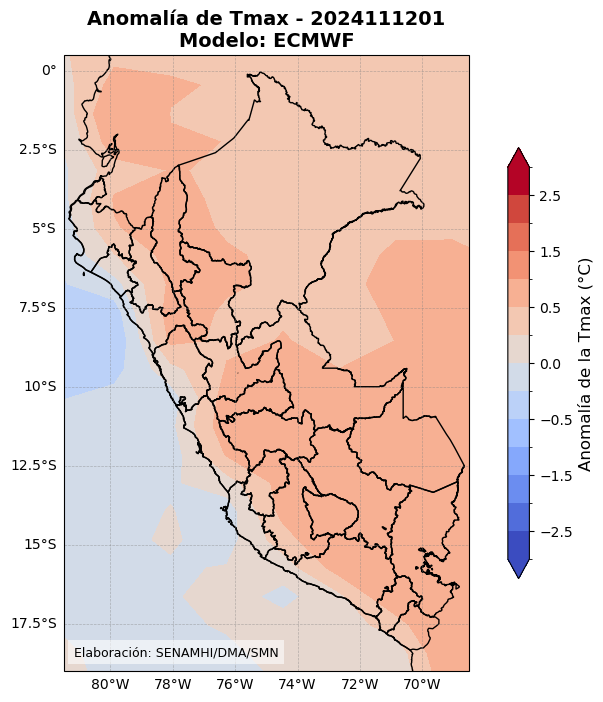

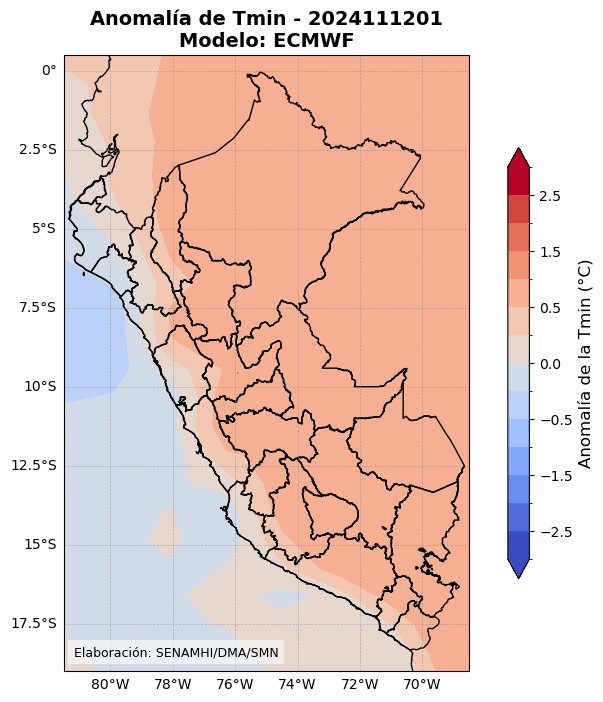

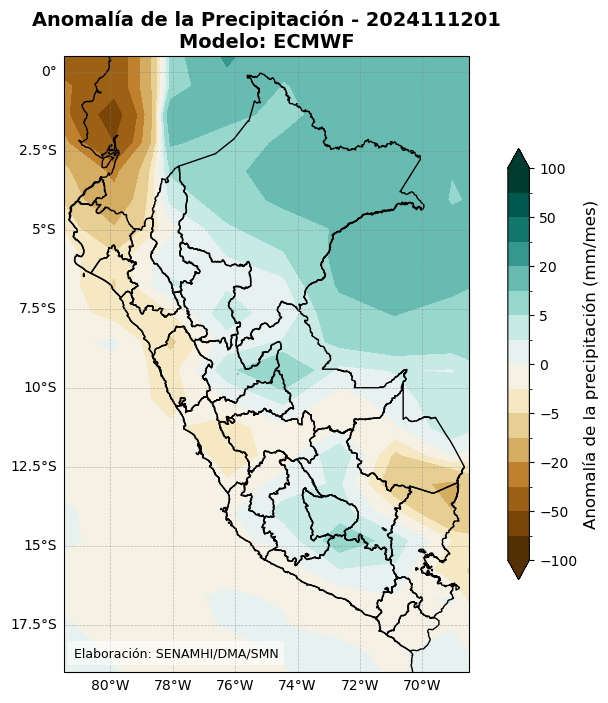

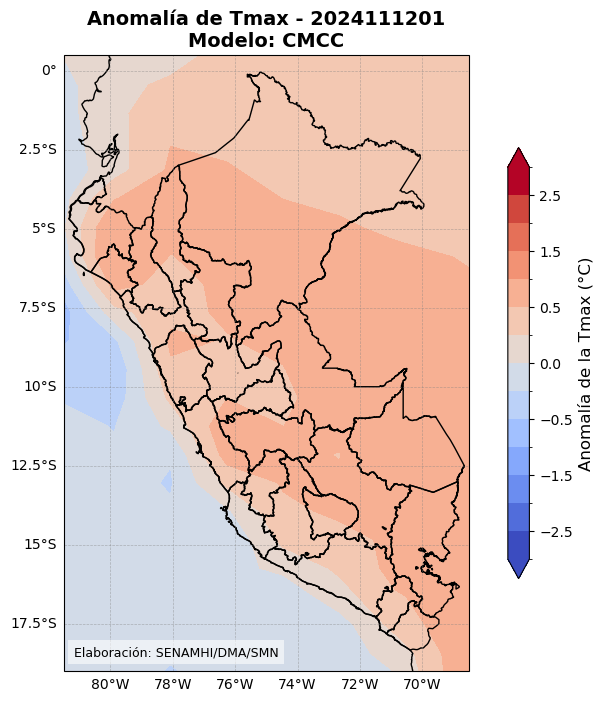

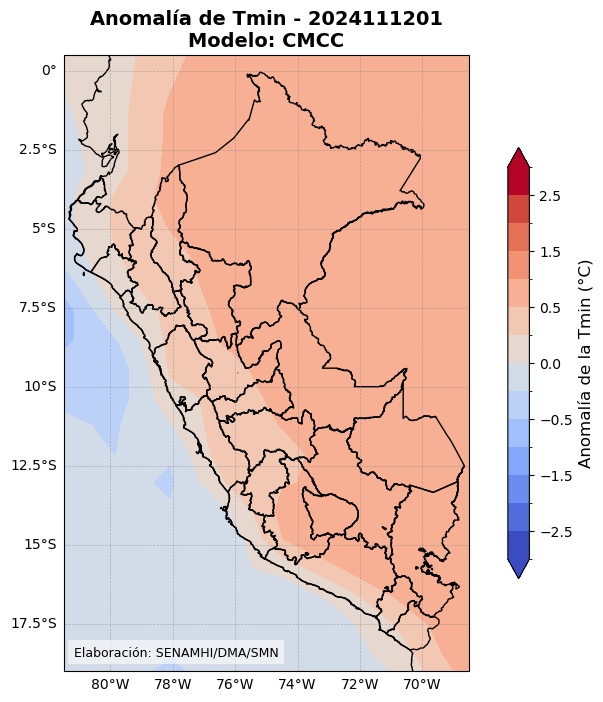

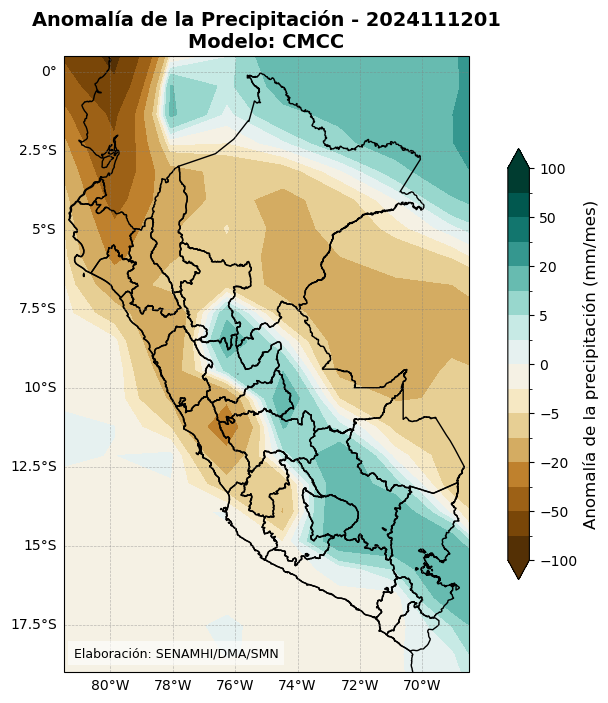

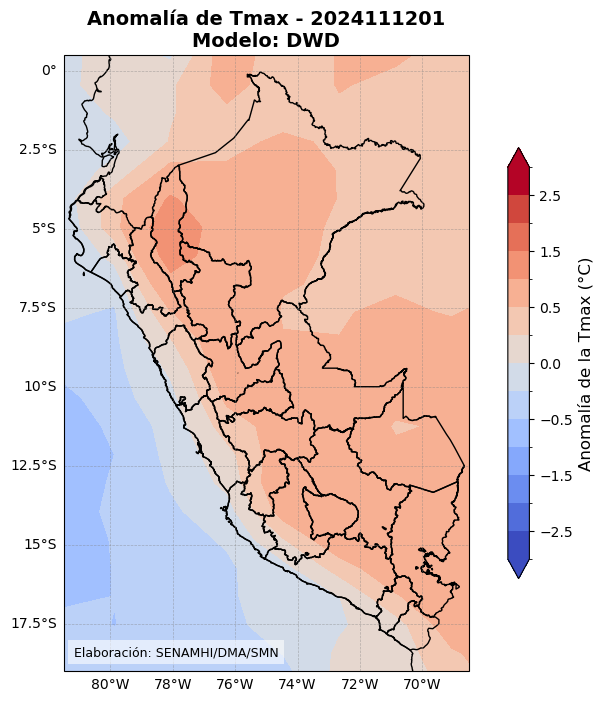

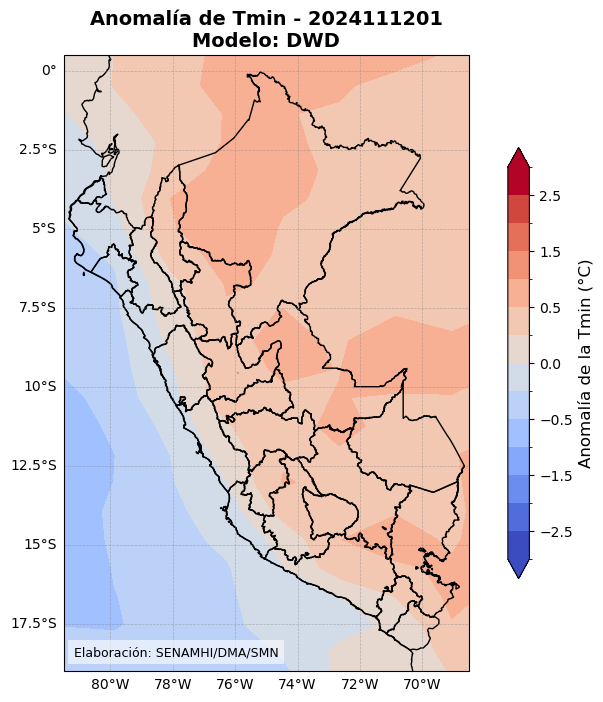

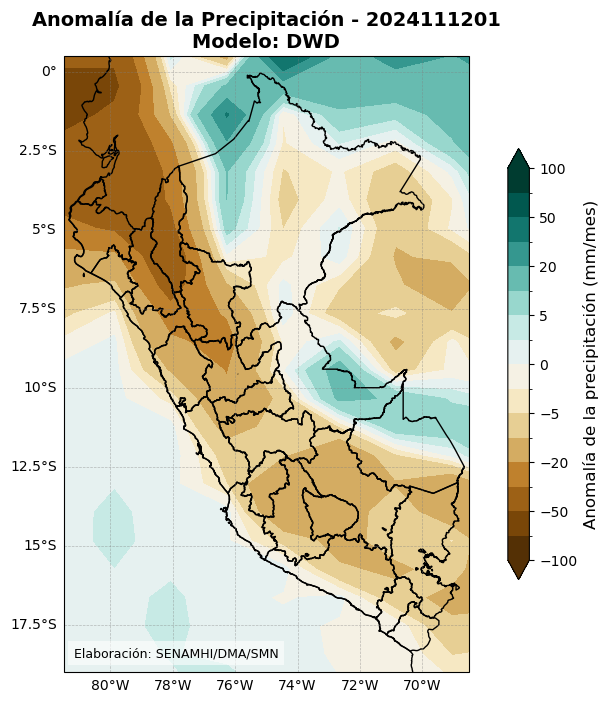

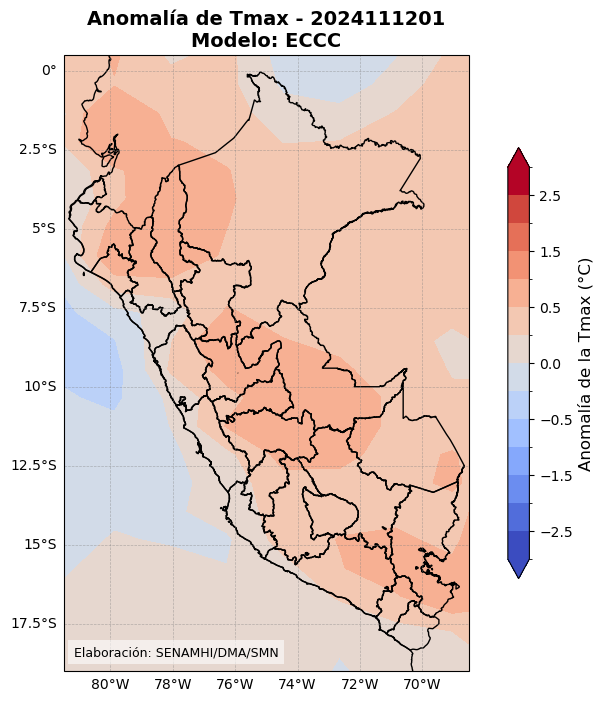

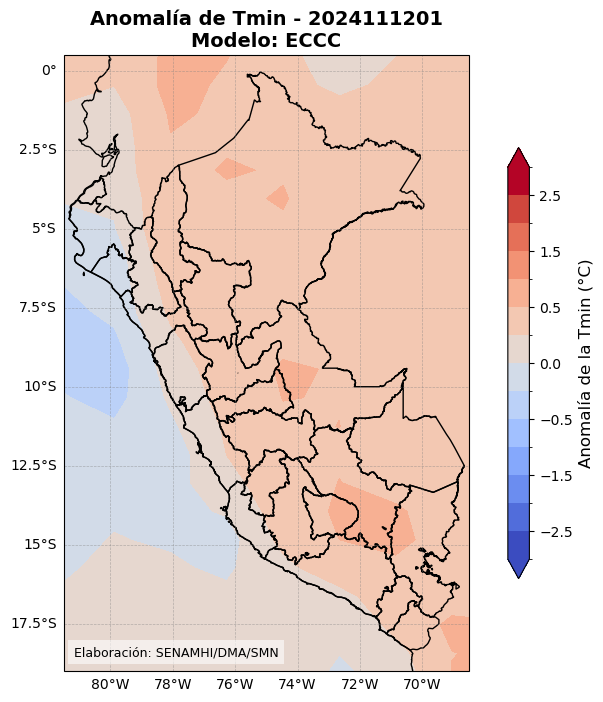

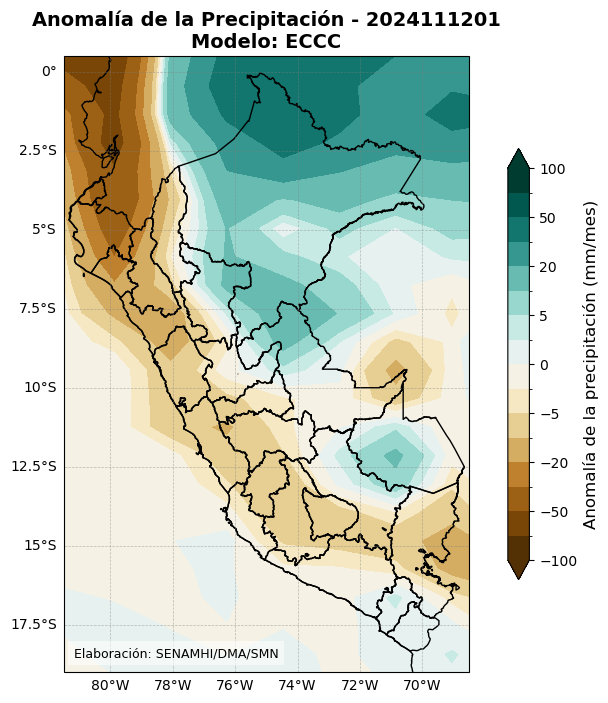

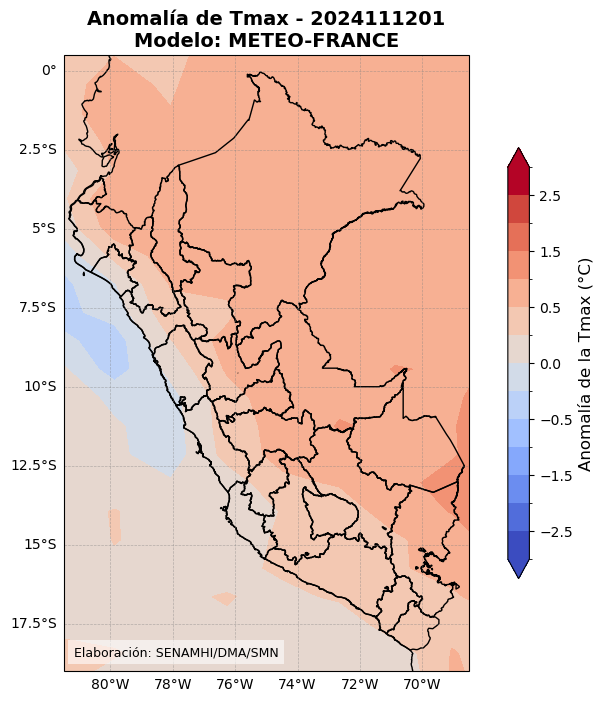

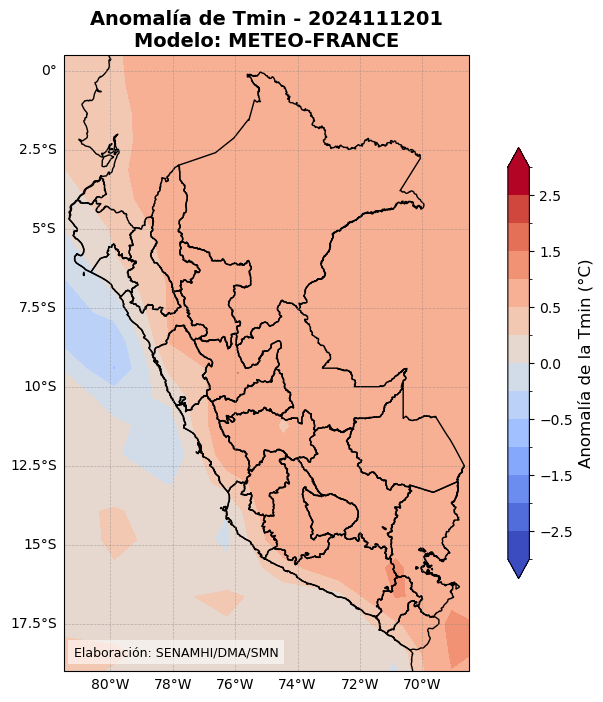

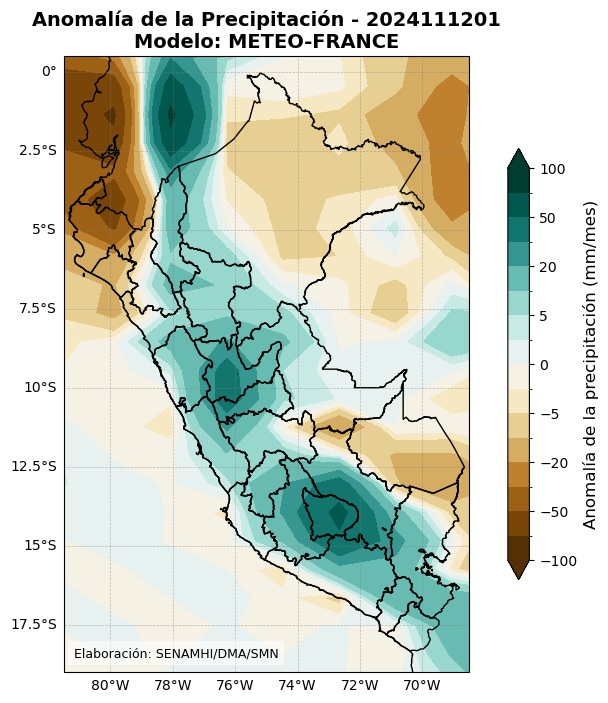

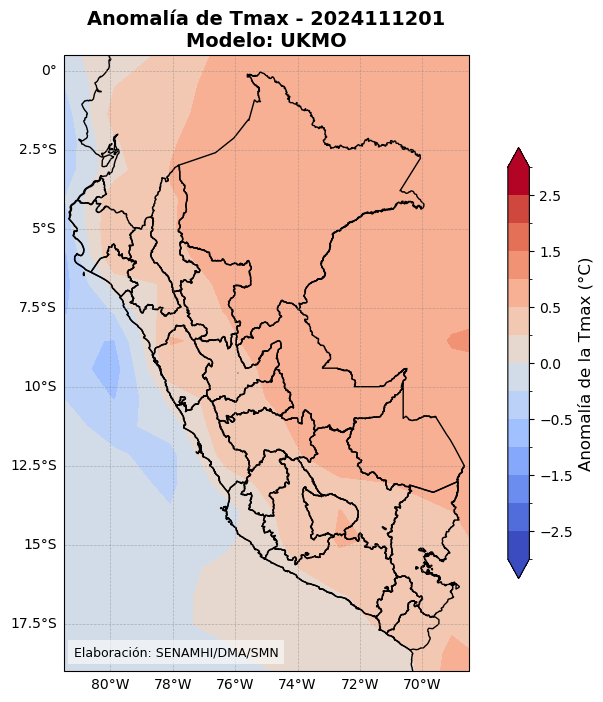

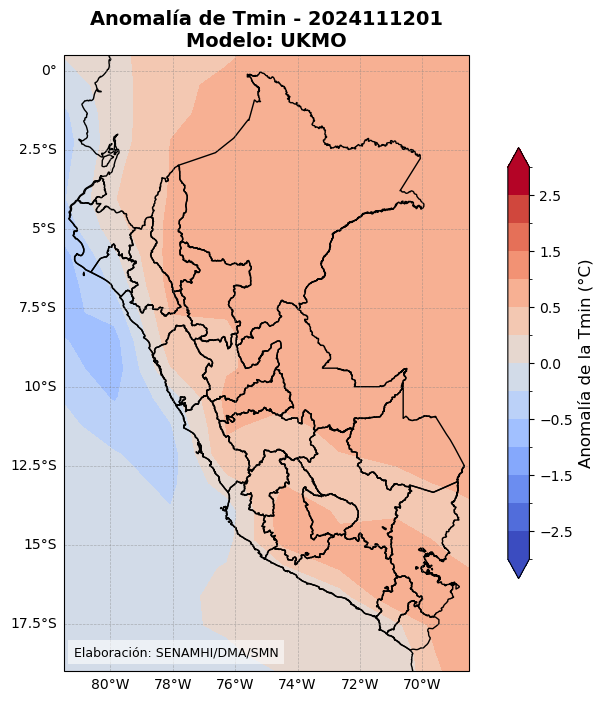

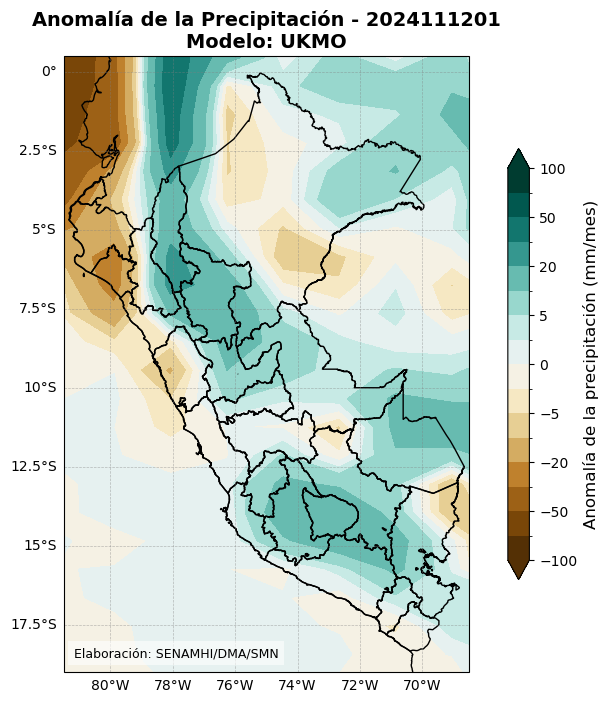

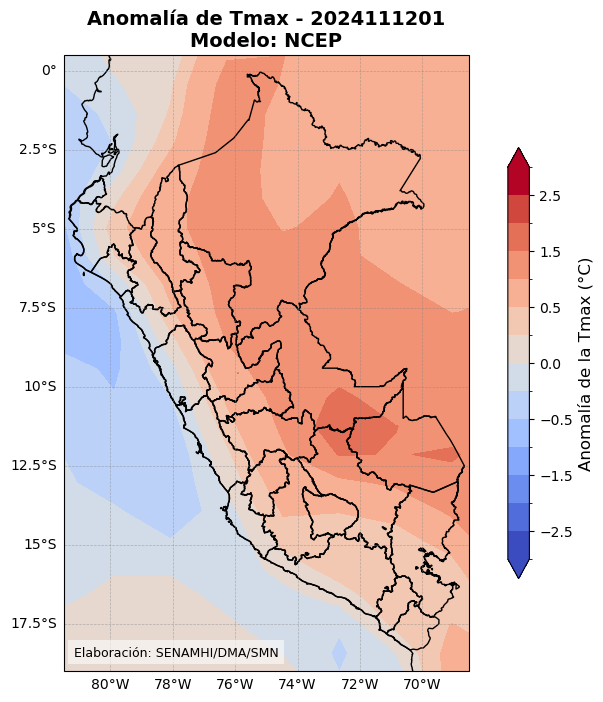

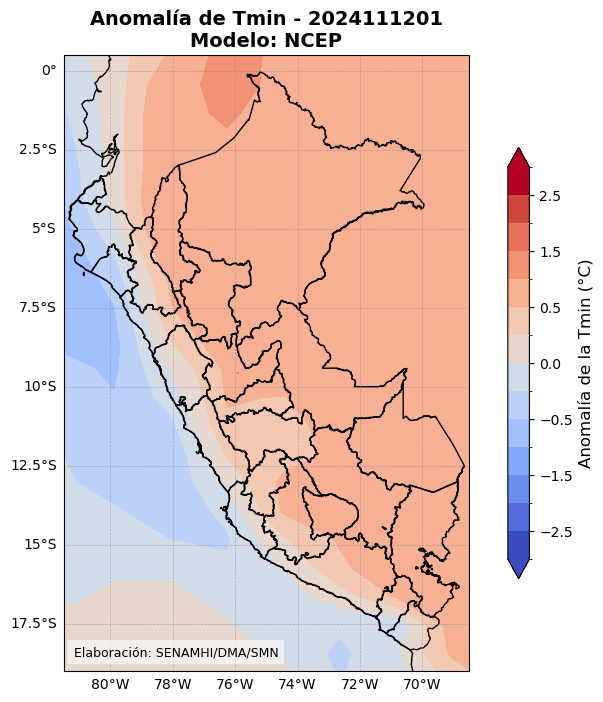

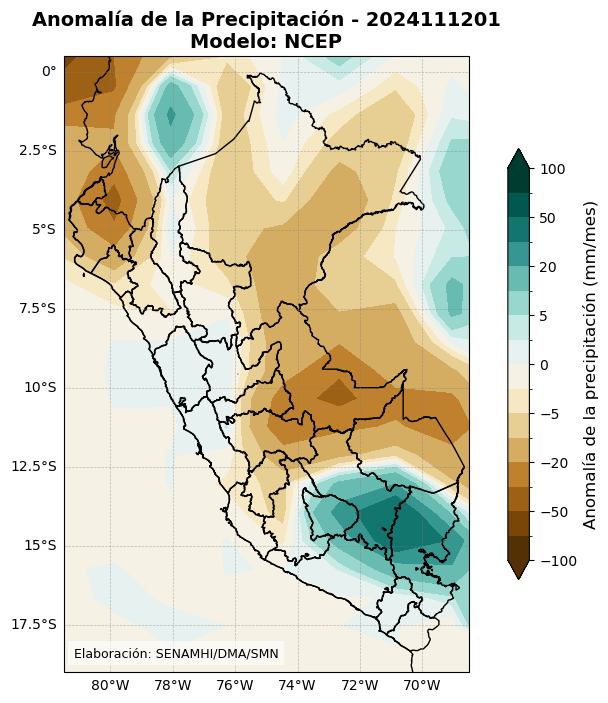

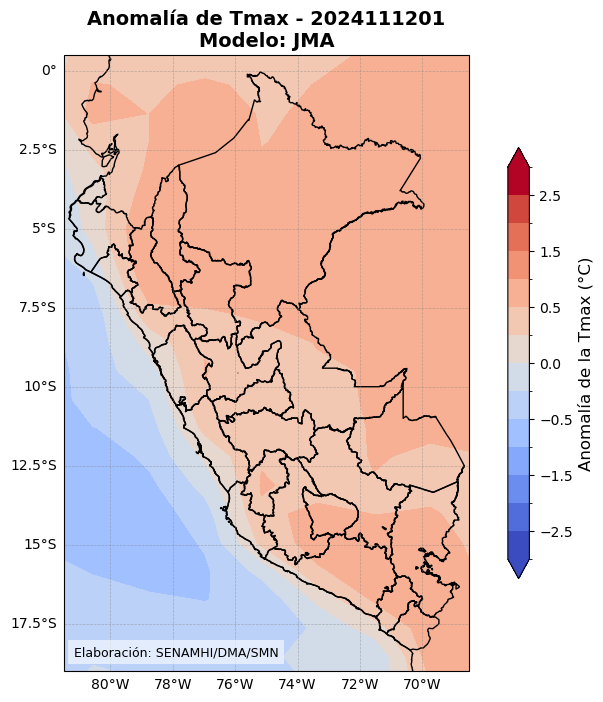

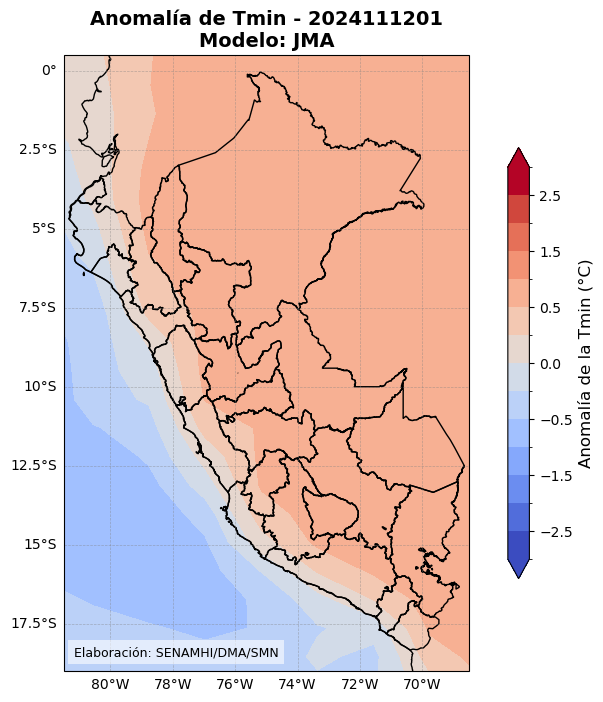

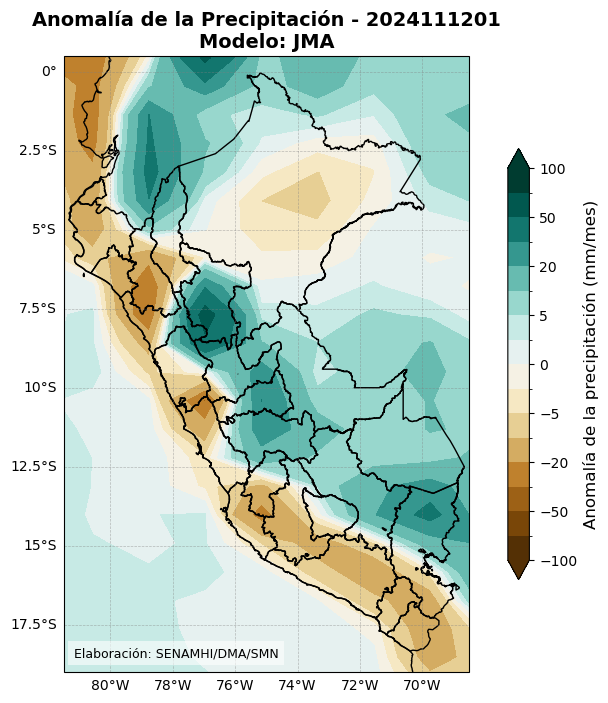

In [4]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import BoundaryNorm
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.ticker as mticker

# Fecha inicial en formato 'YYYYMM', se define una sola vez
FECHA_INICIAL = '202410'

# Definir la función para interpolar los datos
def cubic_interpolation(variable, lon, lat, new_lon, new_lat):
    lon2d, lat2d = np.meshgrid(lon, lat)
    points = np.array([lon2d.flatten(), lat2d.flatten()]).T
    values = variable.values.flatten()

    new_lon2d, new_lat2d = np.meshgrid(new_lon, new_lat)
    new_points = np.array([new_lon2d.flatten(), new_lat2d.flatten()]).T

    interpolated_values = griddata(points, values, new_points, method='cubic')
    return interpolated_values.reshape(new_lon2d.shape)

# Definir la función para crear y mostrar los gráficos
def plot_variable(variable, variable_name, cmap, bounds, norm, title_prefix, output_dir, filename_suffix, colorbar_label, modelo, ref_time):
    # Promedio trimestral de los meses 2, 3 y 4
    if 'forecastMonth' in variable.coords:
        variable_avg = variable.sel(forecastMonth=[2, 3, 4]).mean(dim='forecastMonth')
    else:
        return

    # Obtener la fecha de inicio y los meses correspondientes
    try:
        if isinstance(ref_time, (int, float)) or pd.isnull(ref_time):
            raise ValueError("Invalid ref_time format")
        ref_time_dt = pd.to_datetime(ref_time)
    except (ValueError, TypeError):
        ref_time_dt = pd.Timestamp('1970-01-01')  # Fecha por defecto si falla la conversión

    date_str = f"{ref_time_dt.year}{(ref_time_dt + pd.DateOffset(months=1)).strftime('%m')}" \
               f"{(ref_time_dt + pd.DateOffset(months=2)).strftime('%m')}" \
               f"{(ref_time_dt + pd.DateOffset(months=3)).strftime('%m')}"

    lon = variable_avg['longitude'].values
    lat = variable_avg['latitude'].values

    new_lon = np.linspace(lon.min(), lon.max(), 200)
    new_lat = np.linspace(lat.min(), lat.max(), 200)

    interpolated_values = cubic_interpolation(variable_avg, lon, lat, new_lon, new_lat)

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    if not np.isnan(interpolated_values).all():
        plot = ax.contourf(new_lon, new_lat, interpolated_values, levels=bounds, cmap=cmap, norm=norm, extend='both', transform=ccrs.PlateCarree())

        shapefile.plot(ax=ax, facecolor='none', edgecolor='black')

        ax.set_title(f'{title_prefix} - {date_str}\nModelo: {modelo.upper()}', fontsize=14, fontweight='bold')

        ax.set_extent(extent)

        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.MultipleLocator(2)
        gl.ylocator = mticker.MultipleLocator(2.5)
        gl.top_labels = False
        gl.right_labels = False

        ax.coastlines()
        cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.7)
        cbar.set_label(colorbar_label, fontsize=12)

        ax.text(0.53, 0.02, 'Elaboración: SENAMHI/DMA/SMN', 
                horizontalalignment='right', verticalalignment='bottom', 
                transform=ax.transAxes, fontsize=9, color='black', 
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        filename = f'pre_{modelo}_{date_str}_{filename_suffix}_per.png'
        plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
        plt.show()

    else:
        ax.set_title(f'Datos no disponibles - {date_str}')
        ax.set_extent(extent)
        plt.show()

    plt.close()

# Lista de modelos a procesar
modelos = ['ecmwf', 'cmcc', 'dwd', 'eccc', 'meteo-france', 'ukmo', 'ncep', 'jma']
#modelos = ['ECMWF', 'CMCC', 'DWD', 'ECCC', 'METEO-FRANCE', 'UKMO', 'NCEP', 'JMA']

# Parámetros para las variables con los intervalos invertidos
variables_info = {
    'mx2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmax',
        'filename_suffix': 'anomTempMax',
        'colorbar_label': 'Anomalía de la Tmax (°C)'
    },
    'mn2t24a': {
        'cmap': 'coolwarm',
        'bounds': np.array([-3, -2.5, -2, -1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3]),
        'title_prefix': 'Anomalía de Tmin',
        'filename_suffix': 'anomTempMin',
        'colorbar_label': 'Anomalía de la Tmin (°C)'
    },
    'tpara': {
        'cmap': 'BrBG',
        'bounds': np.array([-100, -80, -50, -30, -20, -10, -5, -2.5, 0, 2.5, 5, 10, 20, 30, 50, 80, 100]),
        'title_prefix': 'Anomalía de la Precipitación',
        'filename_suffix': 'anomPrec',
        'colorbar_label': 'Anomalía de la precipitación (mm/mes)'
    }
}

# Cargar el shapefile
shapefile = gpd.read_file('/scratch/shape/SHAPES/DEPARTAMENTOS.shp')
extent = [-81.5, -68.5, -19, 0.5]

# Obtener la fecha de referencia del modelo ECMWF
ds_ecmwf = xr.open_dataset(f'/scratch/DMA/SMN/CLIMA/C3S/{FECHA_INICIAL}/flx.anom.ecmwf.nc')
ref_time_ecmwf = ds_ecmwf['forecast_reference_time'].values[0] if 'forecast_reference_time' in ds_ecmwf else pd.Timestamp('1970-01-01')

# Procesar cada modelo
for modelo in modelos:
    ds = xr.open_dataset(f'/scratch/DMA/SMN/CLIMA/C3S/{FECHA_INICIAL}/flx.anom.{modelo}.nc')

    if 'tpara' in ds:
        segundos_por_mes = 30 * 24 * 3600
        ds['tpara'] = ds['tpara'] * 1000 * segundos_por_mes

    # Para NCEP y JMA, usar la fecha de ECMWF
    if modelo in ['ncep', 'jma']:
        ref_time = ref_time_ecmwf
    else:
        ref_time = ds['forecast_reference_time'].values[0] if 'forecast_reference_time' in ds else pd.Timestamp('1970-01-01')

    fecha_inicio = pd.to_datetime(ref_time).strftime('%Y%m')
    output_dir = '/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/trimestral'
    os.makedirs(output_dir, exist_ok=True)

    for var, info in variables_info.items():
        if var in ds:
            variable = ds[var]
            norm = BoundaryNorm(boundaries=info['bounds'], ncolors=256)
            plot_variable(variable, var, info['cmap'], info['bounds'], norm, info['title_prefix'], output_dir, info['filename_suffix'], info['colorbar_label'], modelo, ref_time)


<xarray.Dataset> Size: 8MB
Dimensions:        (forecastMonth: 6, latitude: 145, longitude: 288)
Coordinates:
    number         int64 8B ...
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
  * latitude       (latitude) float64 1kB 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * longitude      (longitude) float64 2kB 0.0 1.25 2.5 ... 356.2 357.5 358.8
Data variables:
    ua10           (forecastMonth, latitude, longitude) float32 1MB ...
    va10           (forecastMonth, latitude, longitude) float32 1MB ...
    mx2t24a        (forecastMonth, latitude, longitude) float32 1MB ...
    msla           (forecastMonth, latitude, longitude) float32 1MB ...
    mn2t24a        (forecastMonth, latitude, longitude) float32 1MB ...
    ssta           (forecastMonth, latitude, longitude) float32 1MB ...
    tpara          (forecastMonth, latitude, longitude) float64 2MB -0.4519 ....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             rjtd
    GRIB_centreDescription:  Japanese Meteorological Agency - Tokyo
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             Japanese Meteorological Agency - Tokyo
    history:                 2024-10-22T14:19 GRIB to CDM+CF via cfgrib-0.9.1...

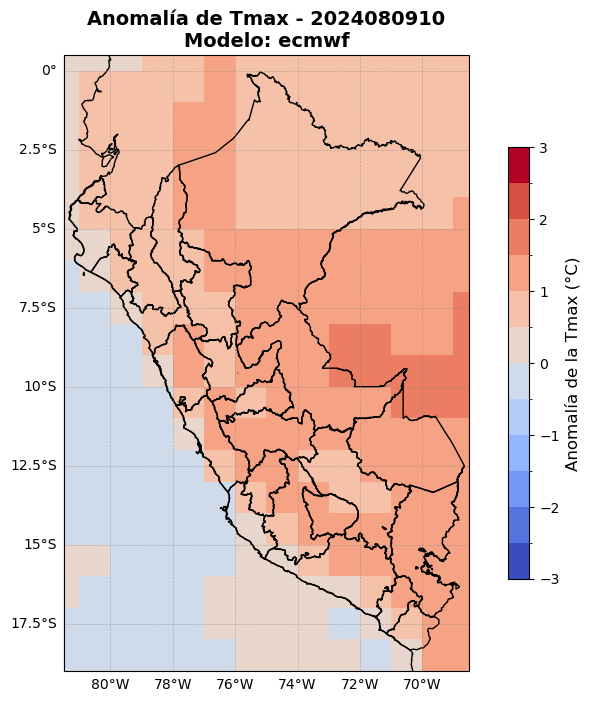

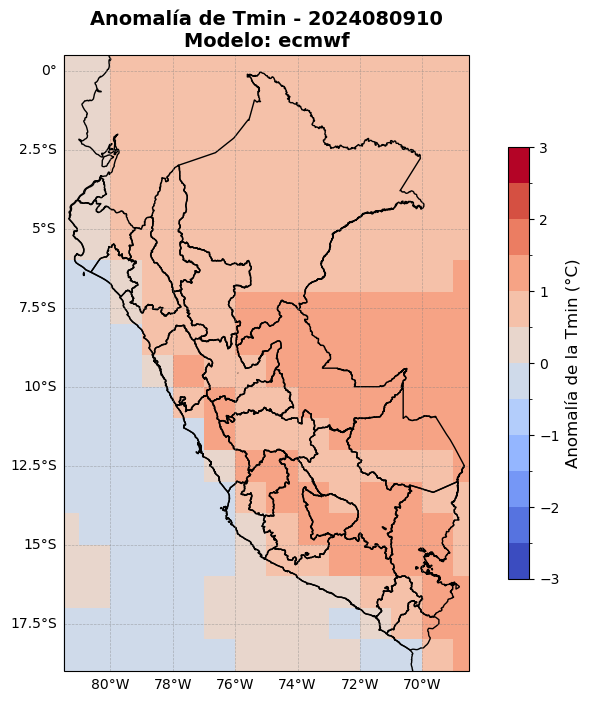

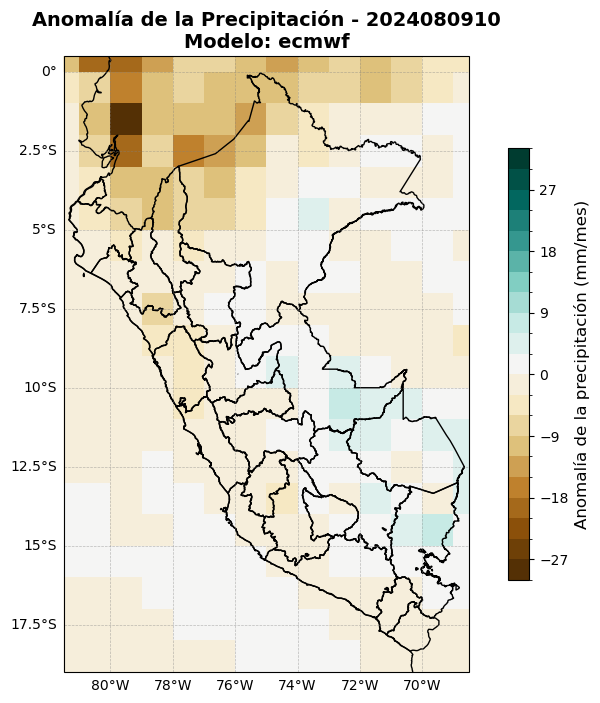

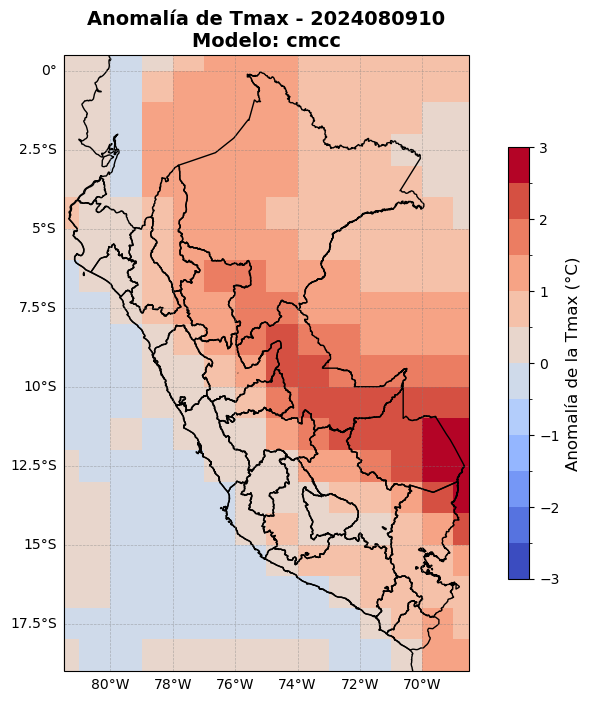

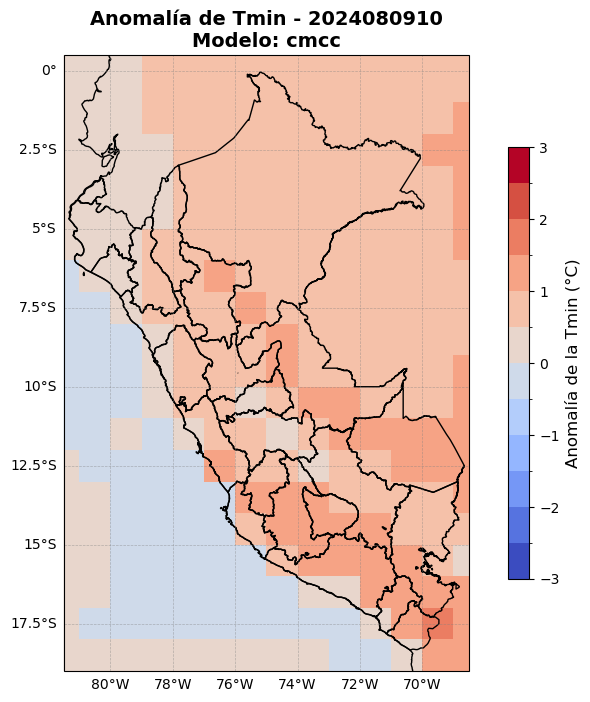

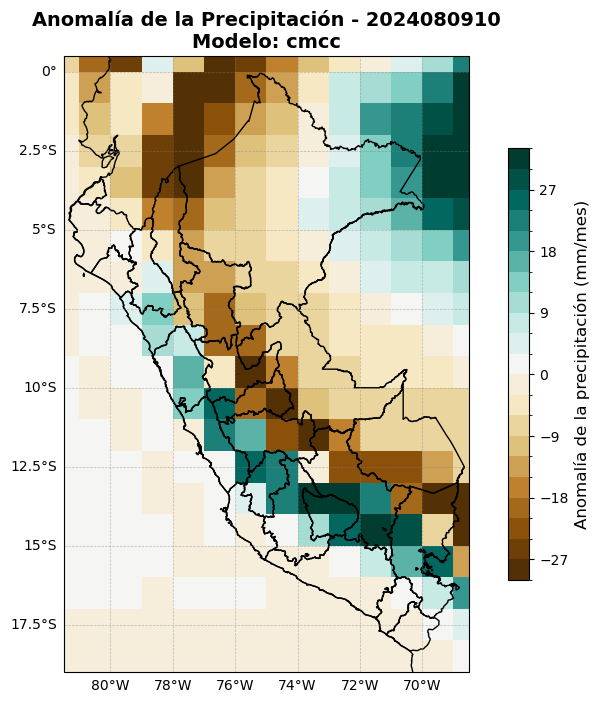

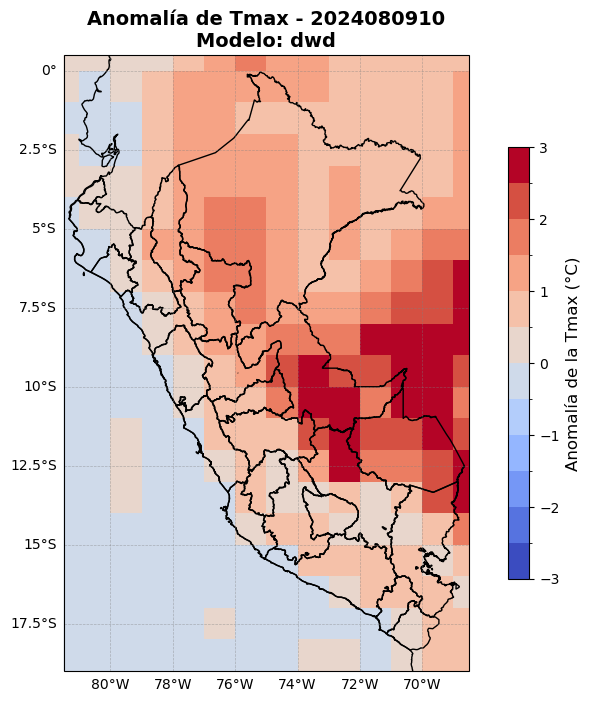

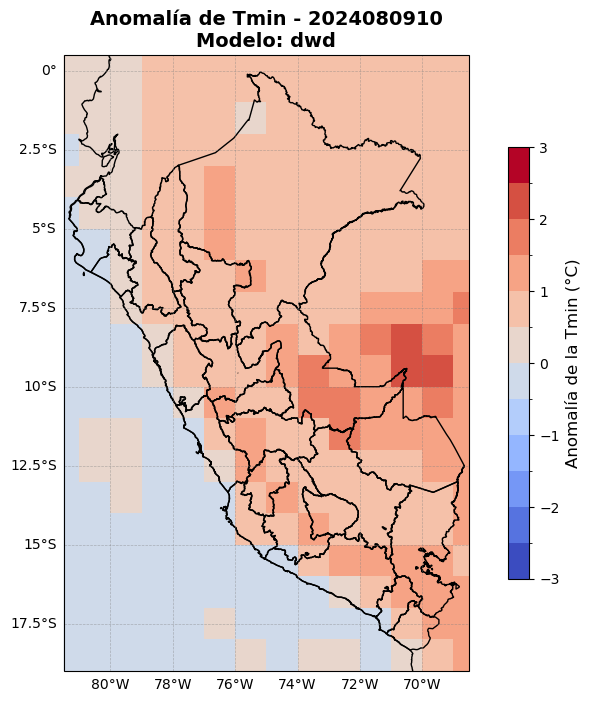

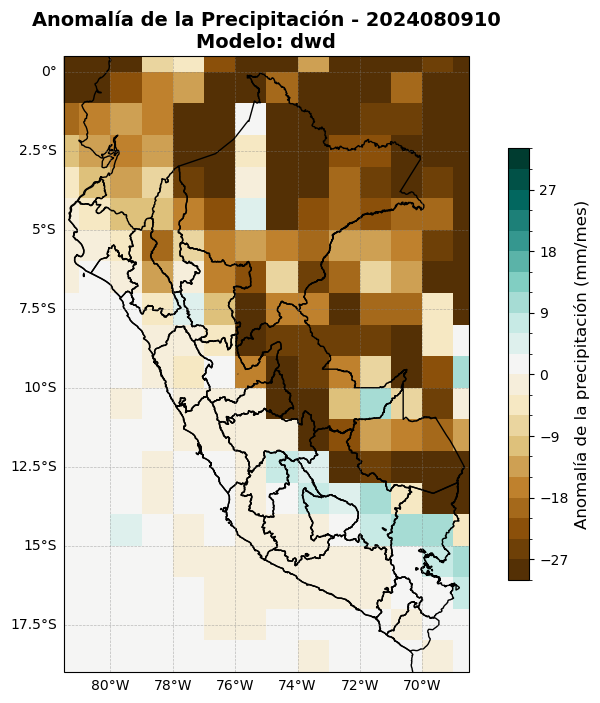

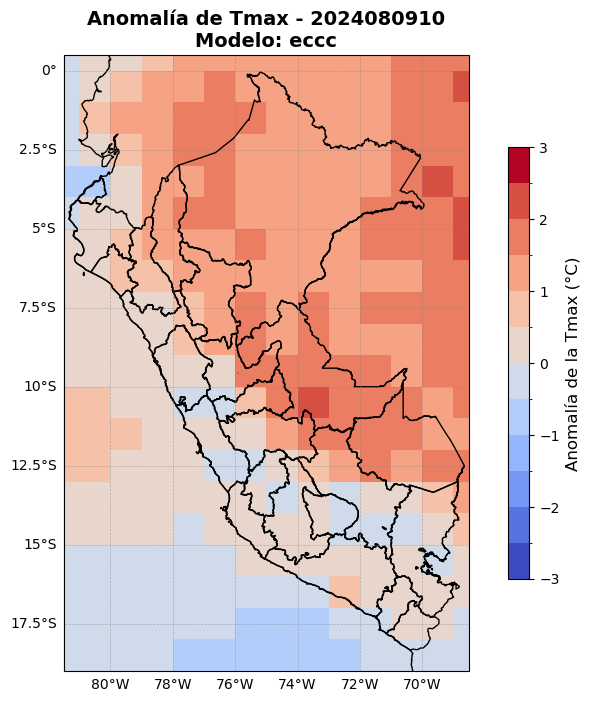

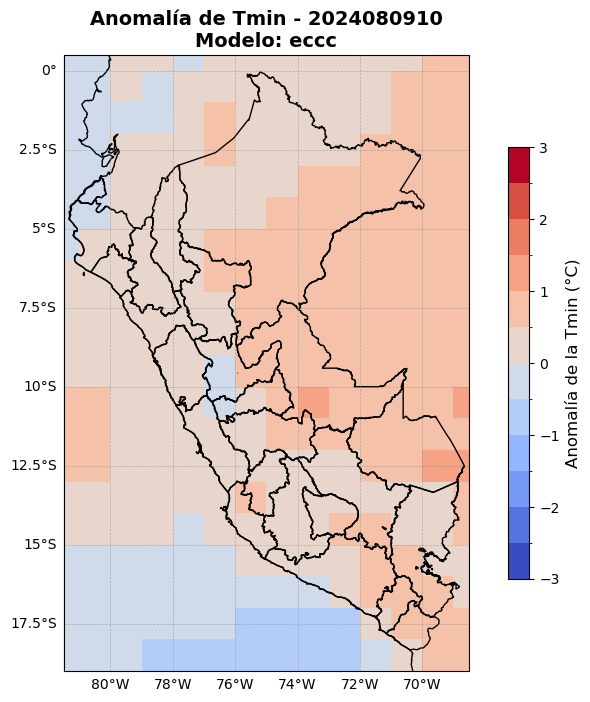

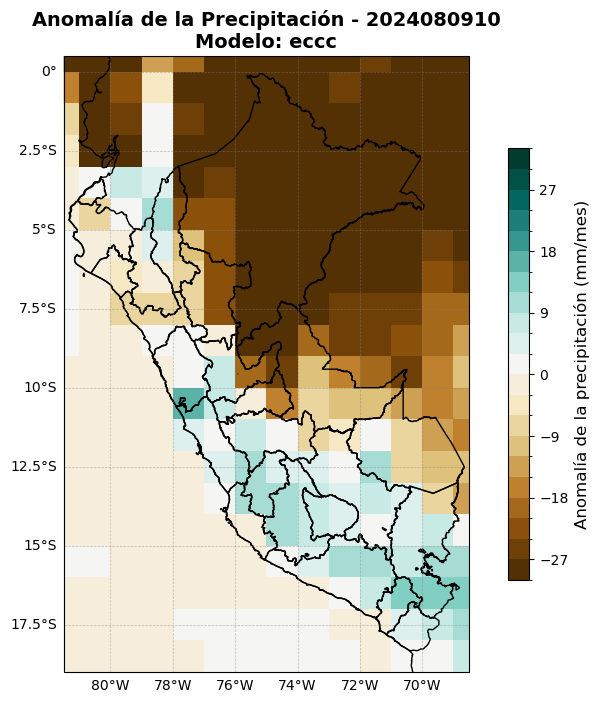

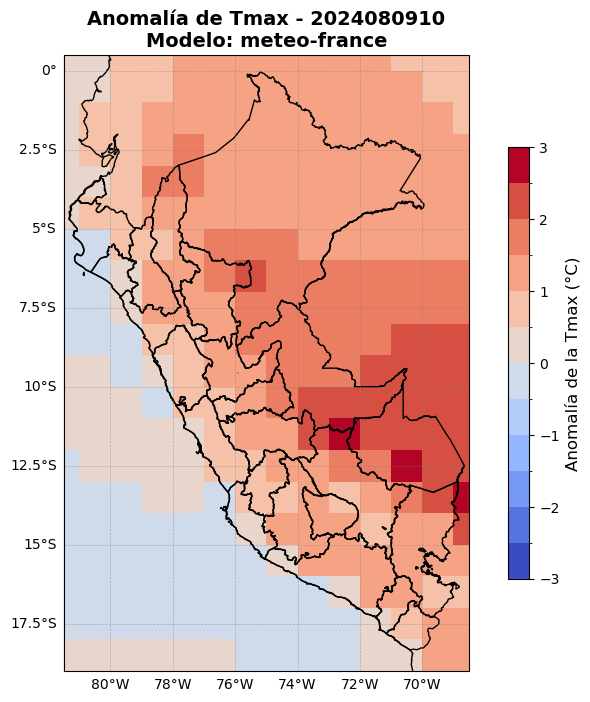

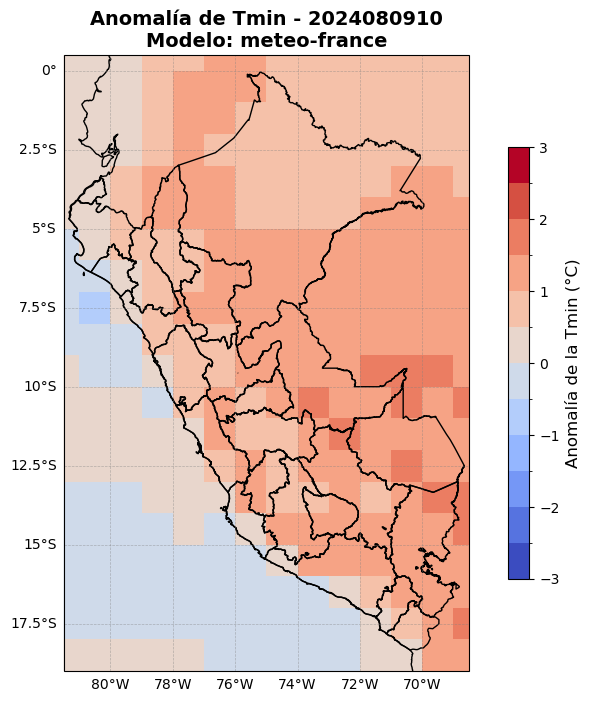

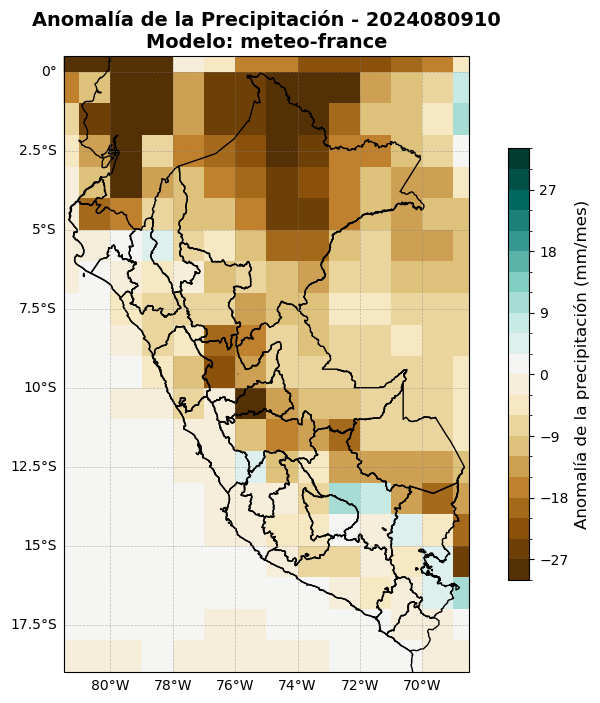

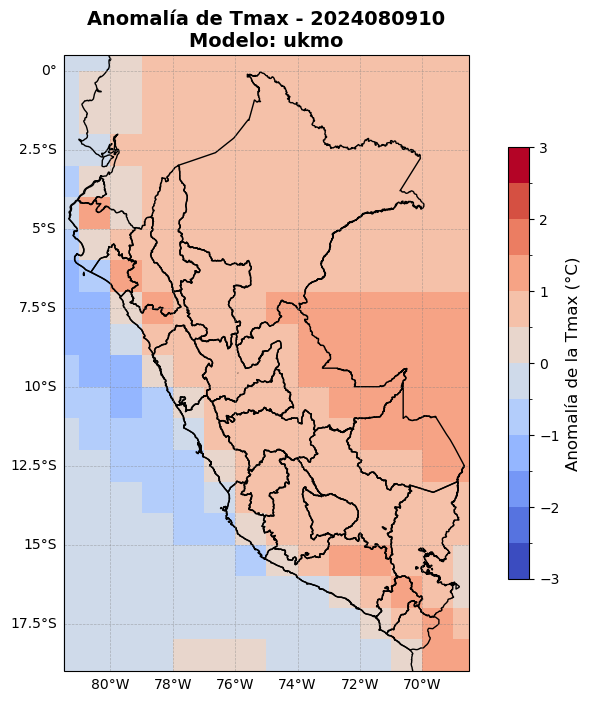

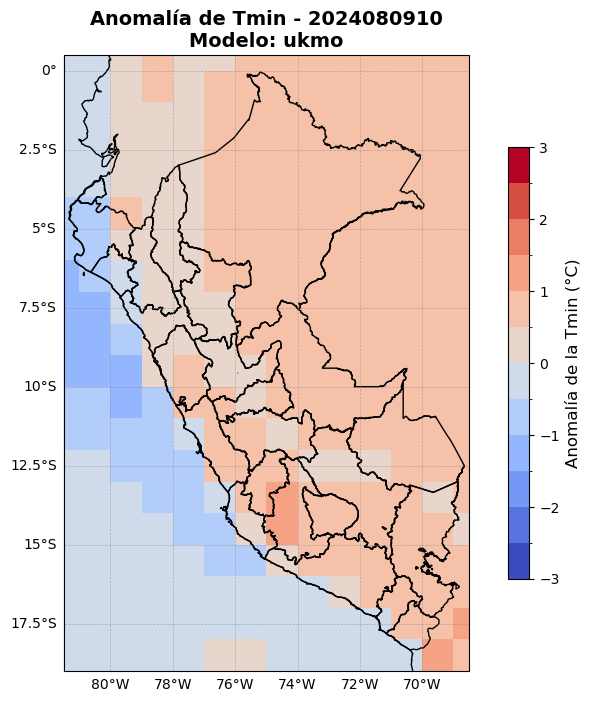

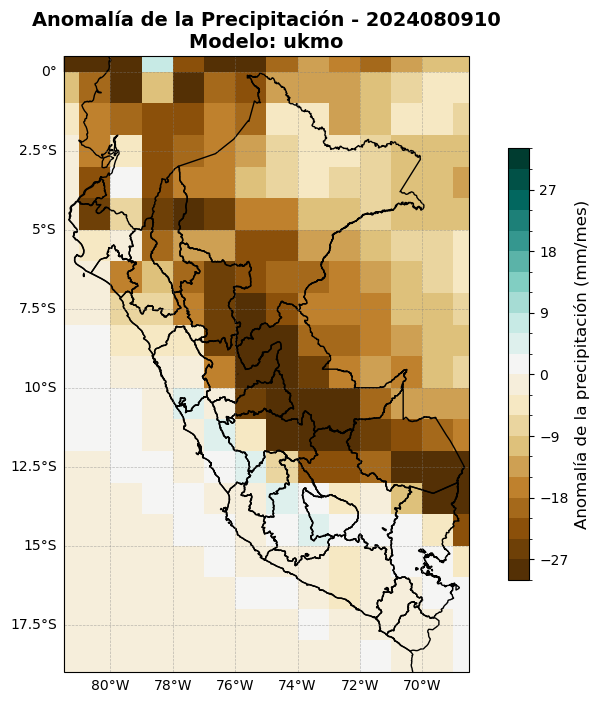

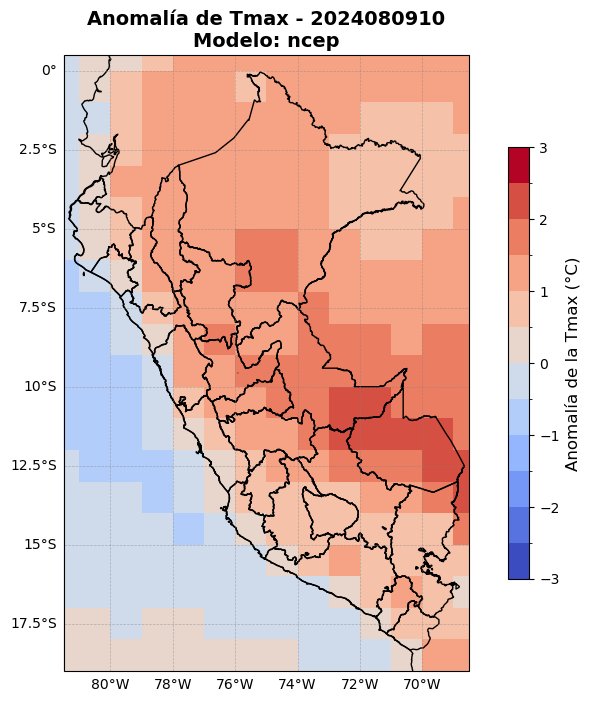

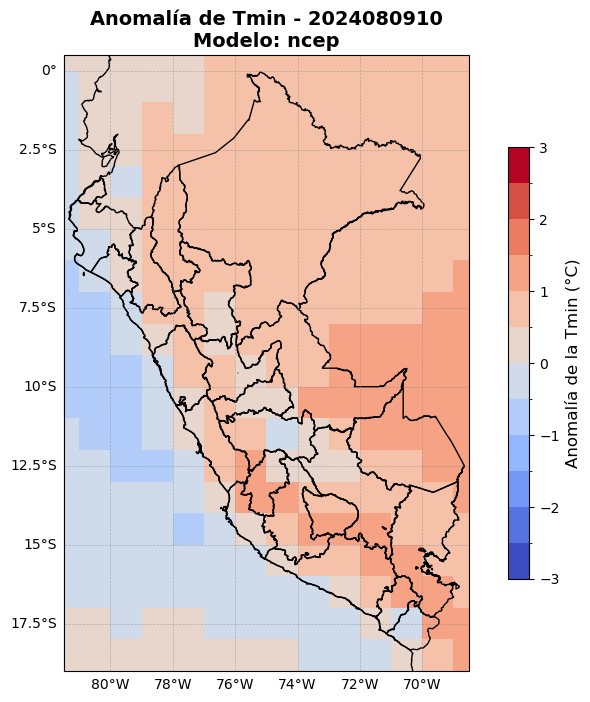

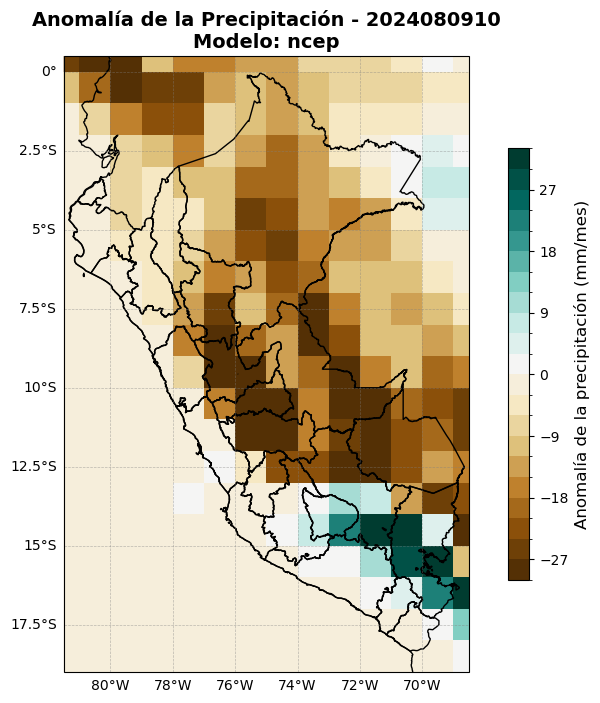

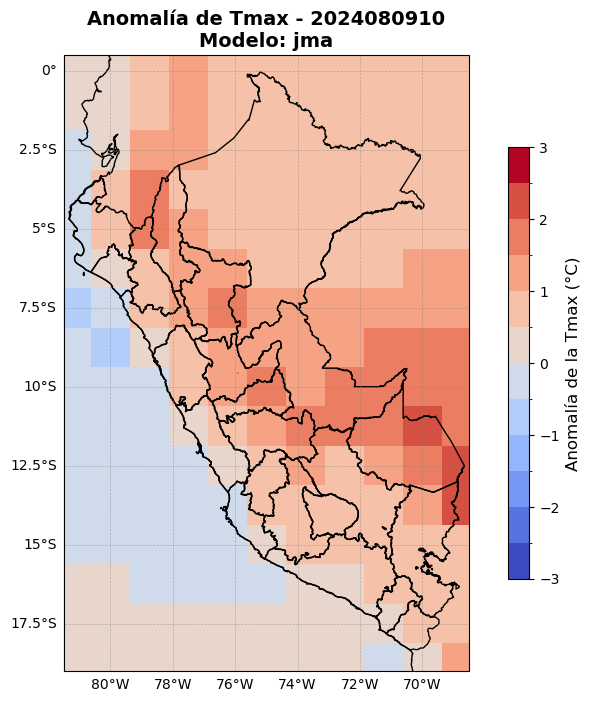

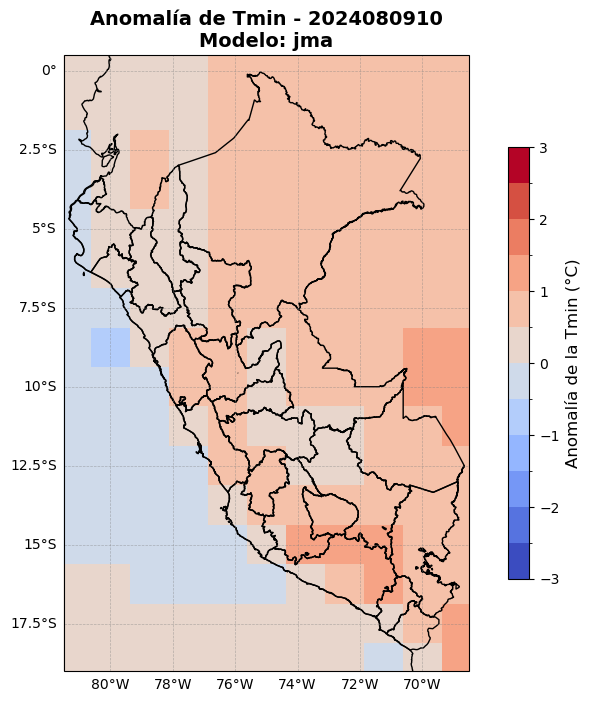

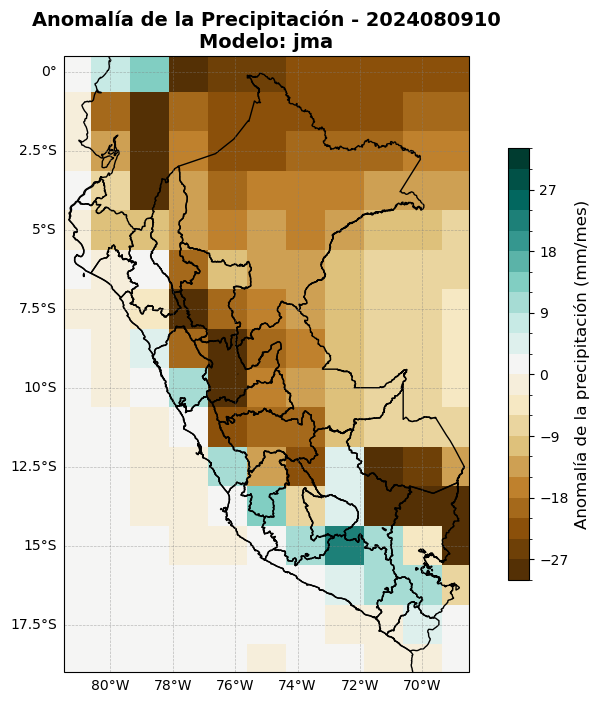

In [5]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from matplotlib.colors import BoundaryNorm

# Definir la función para crear y mostrar los gráficos
def plot_variable(variable, variable_name, cmap, bounds, norm, title_prefix, output_dir, filename_suffix, colorbar_label, modelo, fecha_nombre):
    # Crear la figura
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Intentar trazar solo si hay datos válidos y no todos son NaN
    if not np.isnan(variable).all():
        plot = variable.plot(
            ax=ax, transform=ccrs.PlateCarree(), x='longitude', y='latitude',
            add_colorbar=False, cmap=cmap, norm=norm, extend='both'
        )

        # Agregar el shapefile
        shapefile.plot(ax=ax, facecolor='none', edgecolor='black')

        # Ajustar el título con la fecha
        ax.set_title(f'{title_prefix} - {fecha_nombre}\nModelo: {modelo}', fontsize=14, fontweight='bold')

        # Ajustar los límites del gráfico
        ax.set_extent(extent)

        # Añadir grilla de coordenadas y configurar las etiquetas
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        # Añadir costas
        ax.coastlines()

        # Añadir barra de colores con la leyenda correspondiente
        cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.7)
        cbar.set_label(colorbar_label, fontsize=12)

        # Guardar la figura con el formato requerido
        filename = f'pre_{modelo}_{fecha_nombre}_{filename_suffix}_per.png'
        plt.savefig(os.path.join(output_dir, filename), dpi=200, bbox_inches='tight')

        # Mostrar la figura
        plt.show()

    else:
        ax.set_title(f'Datos no disponibles - {fecha_nombre}')
        ax.set_extent(extent)
        plt.show()

    plt.close()

# Lista de modelos a procesar
modelos = ['ecmwf', 'cmcc', 'dwd', 'eccc', 'meteo-france', 'ukmo', 'ncep', "jma"]
#modelos = ['ecmwf']
# Parámetros para las variables
variables_info = {
    'mx2t24a': {'cmap': 'coolwarm', 'bounds': np.arange(-3, 3.5, 0.5), 'title_prefix': 'Anomalía de Tmax', 'filename_suffix': 'anomTempMax', 'colorbar_label': 'Anomalía de la Tmax (°C)'},
    'mn2t24a': {'cmap': 'coolwarm', 'bounds': np.arange(-3, 3.5, 0.5), 'title_prefix': 'Anomalía de Tmin', 'filename_suffix': 'anomTempMin', 'colorbar_label': 'Anomalía de la Tmin (°C)'},
    'tpara': {'cmap': 'BrBG', 'bounds': np.arange(-30, 35, 3), 'title_prefix': 'Anomalía de la Precipitación', 'filename_suffix': 'anomPrec', 'colorbar_label': 'Anomalía de la precipitación (mm/mes)'}
}

# Cargar el shapefile
shapefile = gpd.read_file('/scratch/shape/SHAPES/DEPARTAMENTOS.shp')

# Coordenadas y límites para Perú
extent = [-81.5, -68.5, -19, 0.5]

# Procesar cada modelo
for modelo in modelos:
    # Cargar el archivo NetCDF correspondiente al modelo
    ds = xr.open_dataset(f'/scratch/DMA/SMN/CLIMA/C3S/202407/flx.anom.{modelo}.nc')

    # Convertir precipitación de m/s a mm/mes si es necesario
    if 'tpara' in ds:
        segundos_por_mes = 30 * 24 * 3600
        ds['tpara'] = ds['tpara'] * 1000 * segundos_por_mes

    # Calcular el promedio trimestral de los tiempos 2, 3 y 4
    variable_promedio = ds.isel(time=slice(1, 4)).mean(dim='time')

    # Crear el nombre de la fecha
    fecha_inicio = str(ds.time.isel(time=1).dt.strftime('%Y%m').values)
    fecha_nombre = f"{fecha_inicio[:4]}{ds.time.isel(time=1).dt.strftime('%m').values}{ds.time.isel(time=2).dt.strftime('%m').values}{ds.time.isel(time=3).dt.strftime('%m').values}"

    # Ruta de salida sin crear carpeta adicional
    output_dir = '/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/trimestral'

    # Graficar cada variable
    for var, info in variables_info.items():
        if var in ds:
            variable = variable_promedio[var]
            norm = BoundaryNorm(boundaries=info['bounds'], ncolors=256)
            plot_variable(variable, var, info['cmap'], info['bounds'], norm, info['title_prefix'], output_dir, info['filename_suffix'], info['colorbar_label'], modelo, fecha_nombre)
